<span style="font-size:1em; text-align:center">CSE 6748 – Applied Analytics Practicum Summer 2022 </span>

<span style="font-size:2em; text-align:center">Commnet’s Cell Site Performance Anomaly Detection</span>
<p>Nirajan Ramarajar (nramarajar3)</p>

In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import time
from sklearn.decomposition import PCA
# from kats.consts import TimeSeriesData
# from kats.detectors.outlier import OutlierDetector
# from sklearn.ensemble import IsolationForest
# from sklearn.cluster import DBSCAN

# import sys
# # print(sys.version)

# # #!{sys.executable} -m pip install numpy
# # #!{sys.executable} -m pip install scikit-image
# # !{sys.executable} -m pip install kats
# # #pip install kats
# !{sys.executable} -m pip install bayesian-changepoint-detection
# !{sys.executable} -m pip install pillow

## Open SQLite Annomaly DB and read the data

In [2]:
data = "hour";

def readData(bts_id="10-1"):
    con = sqlite3.connect("data/anomaly.db")
    query = "SELECT * from testdata_hour where BTS_ID='%s'" % bts_id;
    df = pd.read_sql_query(query, con)
    return df

def printData(df):
    print(df.shape)
    print(df.head())
    print (df.info())
    print ( df.describe())


### Check for null if any in the data. test data does not have null

In [3]:
def checkForNull(df):
    print ( df.isnull().any().any())


### Converting day to datetime object

In [4]:
def convertToDateTime(df):
    df1 = df.copy()
    df1['day'] =  pd.to_datetime(df1['day'])
    print("Day object type")
    print(df1[['day']].info())
    return df1


### Droping day and BTS_ID to scale.

In [5]:

def dropCol(df):
    columns_to_drop = ['day', 'BTS_ID']
    df_day = df[['day']]
    df = df.drop(columns_to_drop, axis=1)
    return df
# columns_to_drop = ['day', 'BTS_ID']
# df_day = df1[['day']]
# df1 = df1.drop(columns_to_drop, axis=1)
# print (df1.shape)

### Performaing scaling using RobustScaler to preserve outliers

In [6]:
def scale(df):
    scaler = RobustScaler()
    start_time = time.time()
    np_scaled = scaler.fit_transform(df)
    end_time = time.time()
    print("Scale Time --- %s seconds ---" % (end_time - start_time))
    df2 = pd.DataFrame(np_scaled)
    df2.columns = df.columns
    return df2
# scaler = RobustScaler()
# start_time = time.time()
# np_scaled = scaler.fit_transform(df1)
# end_time = time.time()
# print("Scale Time --- %s seconds ---" % (end_time - start_time))
# df2 = pd.DataFrame(np_scaled)
# df2.columns = df1.columns

In [7]:
df = readData("10-1")
printData (df)
checkForNull(df)
df1 = convertToDateTime(df)
df1 = dropCol(df1)
df2 = scale(df1)
plt.style.use("Solarize_Light2")

(336, 33)
                   day BTS_ID  RRC_Conn_Release_due_to_S1_Link_Fail  \
0  2021-10-27 00:00:00   10-1                                   0.0   
1  2021-10-27 01:00:00   10-1                                   0.0   
2  2021-10-27 02:00:00   10-1                                   0.0   
3  2021-10-27 03:00:00   10-1                                   0.0   
4  2021-10-27 04:00:00   10-1                                   0.0   

   Max_Num_RRC_Conn_User  Mean_RRC_Conn_Setup_Time_ms  \
0                   11.0                      13355.0   
1                   11.0                      13909.0   
2                   12.0                      12593.0   
3                   12.0                      14232.0   
4                   14.0                      13922.0   

   Avg_PRACH_Usage_per_Second  FDD_Cell_DL_Avg_Agg_Thruput_Mbps  \
0                    0.163611                              4.56   
1                    0.220555                              7.18   
2                  

### Correlation of 32 performance indicators.

In [8]:
df2.corr()

,RRC_Conn_Release_due_to_S1_Link_Fail,Max_Num_RRC_Conn_User,Mean_RRC_Conn_Setup_Time_ms,Avg_PRACH_Usage_per_Second,FDD_Cell_DL_Avg_Agg_Thruput_Mbps,FDD_Cell_UL_Avg_Agg_Thruput_Mbps,FDD_Cell_DL_MAC_Data_Volume_MB,FDD_Cell_UL_MAC_Data_Volume_MB,Avg_CQI,FDD_RRC_Est_Success_Pct,...,DL_64QAM_Modulation_Scheme_Usage_Pct,UL_16QAM_Modulation_Scheme_Usage_Pct,FDD_ERAB_Setup_Success_Pct,DL_64QAM_vs_UL_16_ratio,Avg_CQI_to DL_64QAM_ratio,DL_PRB_vs_UL_PRB_ratio,MIMO_Usage_Pct,RSSI_Avg_dBm,PRACH_Avg_NI_dBm,Power_DL_Avg_mw
RRC_Conn_Release_due_to_S1_Link_Fail,1.000000,0.461496,0.049334,0.018272,0.044535,0.108358,0.086601,0.085491,-0.098151,0.029463,...,-0.039189,0.063284,-0.136059,-0.076481,-0.002232,0.128338,-0.009915,0.143975,0.238339,0.130498
Max_Num_RRC_Conn_User,0.461496,1.000000,0.652011,0.575145,0.236493,0.380766,0.365755,0.455599,-0.263521,-0.182206,...,-0.070531,0.286604,-0.356084,-0.328956,-0.016599,0.331961,0.086893,0.427554,0.154178,0.456594
Mean_RRC_Conn_Setup_Time_ms,0.049334,0.652011,1.000000,0.814189,0.001331,0.086686,0.131573,0.185464,-0.418932,-0.209773,...,-0.301987,0.026727,-0.359268,-0.233794,0.147799,0.156061,-0.147958,0.137481,0.156031,0.264822
Avg_PRACH_Usage_per_Second,0.018272,0.575145,0.814189,1.000000,0.060296,0.140891,0.178975,0.232264,-0.387735,-0.277842,...,-0.247294,0.035457,-0.304710,-0.208620,0.126625,0.205564,-0.132165,0.160079,0.174434,0.299492
FDD_Cell_DL_Avg_Agg_Thruput_Mbps,0.044535,0.236493,0.001331,0.060296,1.000000,0.278225,0.808763,0.464077,0.186477,-0.098907,...,0.517140,0.614950,-0.112938,-0.250788,-0.398987,0.687098,0.689549,0.590458,0.216108,0.655071
FDD_Cell_UL_Avg_Agg_Thruput_Mbps,0.108358,0.380766,0.086686,0.140891,0.278225,1.000000,0.355556,0.817944,-0.078563,-0.117293,...,0.180032,0.579224,-0.066820,-0.421411,-0.216011,0.107965,0.390679,0.543426,0.080838,0.312719
FDD_Cell_DL_MAC_Data_Volume_MB,0.086601,0.365755,0.131573,0.178975,0.808763,0.355556,1.000000,0.717225,0.100852,-0.129111,...,0.322169,0.565268,-0.187751,-0.287354,-0.218079,0.803805,0.466931,0.799119,0.283153,0.914062
FDD_Cell_UL_MAC_Data_Volume_MB,0.085491,0.455599,0.185464,0.232264,0.464077,0.817944,0.717225,1.000000,-0.041294,-0.177679,...,0.176060,0.544503,-0.183313,-0.364586,-0.165992,0.410983,0.345872,0.800245,0.204502,0.682194
Avg_CQI,-0.098151,-0.263521,-0.418932,-0.387735,0.186477,-0.078563,0.100852,-0.041294,1.000000,0.008055,...,0.602841,-0.044864,0.059927,0.438285,-0.455652,-0.191897,0.168884,-0.007634,0.047592,-0.140498
FDD_RRC_Est_Success_Pct,0.029463,-0.182206,-0.209773,-0.277842,-0.098907,-0.117293,-0.129111,-0.177679,0.008055,1.000000,...,-0.038743,0.012620,0.344220,-0.045503,0.092100,-0.031130,-0.050102,-0.136319,-0.182400,-0.114552


In [9]:
componentList = []
number_of_components = 1
for i in range(0, number_of_components):
    j = i + 1
    componentList.append("comp"+str(j))
        
def doPCA(dataset):
    start_time = time.time()
    print(componentList)
    pca = PCA(n_components=number_of_components)
    pca.fit(dataset)
    pca_dataset = pca.transform(dataset)
    #saveModel(LE, "PcaModel.ml")
    print ( pca_dataset.shape)
    #print ( final_dataset.shape)
    print ( dataset.shape)
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    return pca_dataset;

def doOneClassSVM(dataset):
    outliers_fraction = 0.2
    start_time = time.time()
    #clf = OneClassSVM(gamma='auto').fit(dataset)
    clf = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01).fit(dataset)
    end_time = time.time()
    print("Fit Time --- %s seconds ---" % (end_time - start_time))
    df1_y = clf.predict(dataset)
    end_predict_time = time.time()
    print("Predict Time --- %s seconds ---" % (end_predict_time - end_time))
    return df1_y

def evaluateClustersKMeans(dataset):
    n_cluster = range(1, 10)
    kmeans = [KMeans(n_clusters=i).fit(dataset) for i in n_cluster]
    scores = [kmeans[i].score(dataset) for i in range(len(kmeans))]
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(n_cluster, scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    #plt.show();
    plt.savefig("./images/KMeans_Cluster_"+data+".png")
    

### Perform PCA to reduce correlation and dimensions

In [10]:
pca_dataset = doPCA(df2)


['comp1']
(336, 1)
(336, 31)
--- 0.5403668880462646 seconds ---


### Performing One Class SVM & plotting anomaly

In [11]:
reduced_data_set = pca_dataset
y_predict = doOneClassSVM(reduced_data_set)
df_pca = pd.DataFrame(reduced_data_set, columns = componentList)
df_pca['time'] =  pd.to_datetime(df['day'])
df_pca = df_pca[['time','comp1']]
df_pca.head()

Fit Time --- 0.003580808639526367 seconds ---
Predict Time --- 0.0037810802459716797 seconds ---


,time,comp1
0,2021-10-27 00:00:00,-1.845746
1,2021-10-27 01:00:00,-1.517364
2,2021-10-27 02:00:00,-1.503065
3,2021-10-27 03:00:00,-1.912222
4,2021-10-27 04:00:00,-1.808782


(array([-1,  1]), array([ 68, 268]))


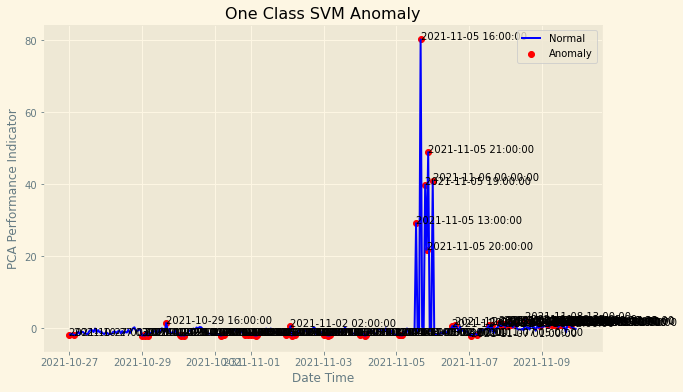

In [12]:
df_plot = df.copy()

df_plot['day'] =  pd.to_datetime(df_plot['day'])
df_plot['anomaly3'] = pd.Series(y_predict)
reduced_data_set[:,0:1].shape
df_plot['comp1'] = reduced_data_set[:,0:1];
# df_plot['comp1'] = pd.Series(reduced_data_set[:,0:1])
#df_plot.head()

print ( np.unique(y_predict, return_counts=True))

fig, ax = plt.subplots(figsize=(10,6))
a = df_plot.loc[df_plot['anomaly3'] == -1, ['day', 'comp1']] #anomaly

ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('One Class SVM Anomaly')
plt.savefig("./images/oneClassSVMAnomaly_"+data+".png")
plt.show();

### K-Means Number of Cluster evaluation (1-10)

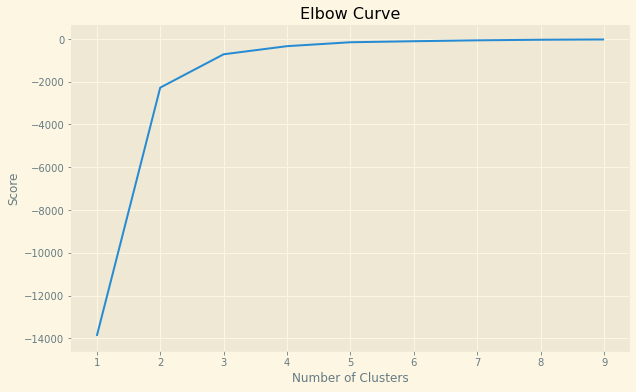

In [13]:
evaluateClustersKMeans(reduced_data_set)

### K-Means with 3 clusters for anomaly detection

In [14]:
km = KMeans(n_clusters=3)
km.fit(reduced_data_set)
y_predict_km=km.predict(reduced_data_set)
df_plot['anomaly4'] = pd.Series(y_predict_km)
print ( np.unique(y_predict_km, return_counts=True))
# df_plot.head()

(array([0, 1, 2], dtype=int32), array([330,   5,   1]))


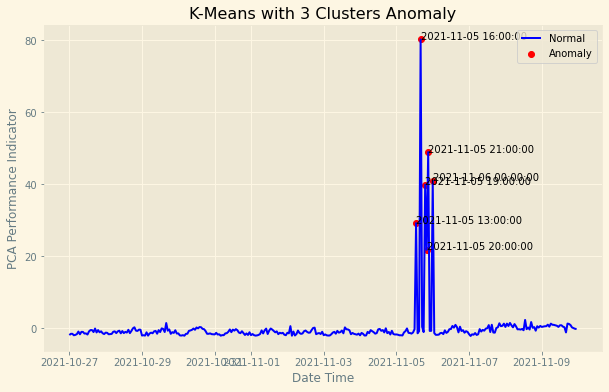

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
a = df_plot.loc[(df_plot['anomaly4'] > 0), ['day', 'comp1']] #anomaly

ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
plt.legend()
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('K-Means with 3 Clusters Anomaly')
plt.savefig("./images/kmeansAnomaly_"+data+".png")
plt.show();

### TimeSeries Decomposition to find Trends, Seasonality and Residual

/Users/nramarajar/opt/anaconda3/envs/Project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


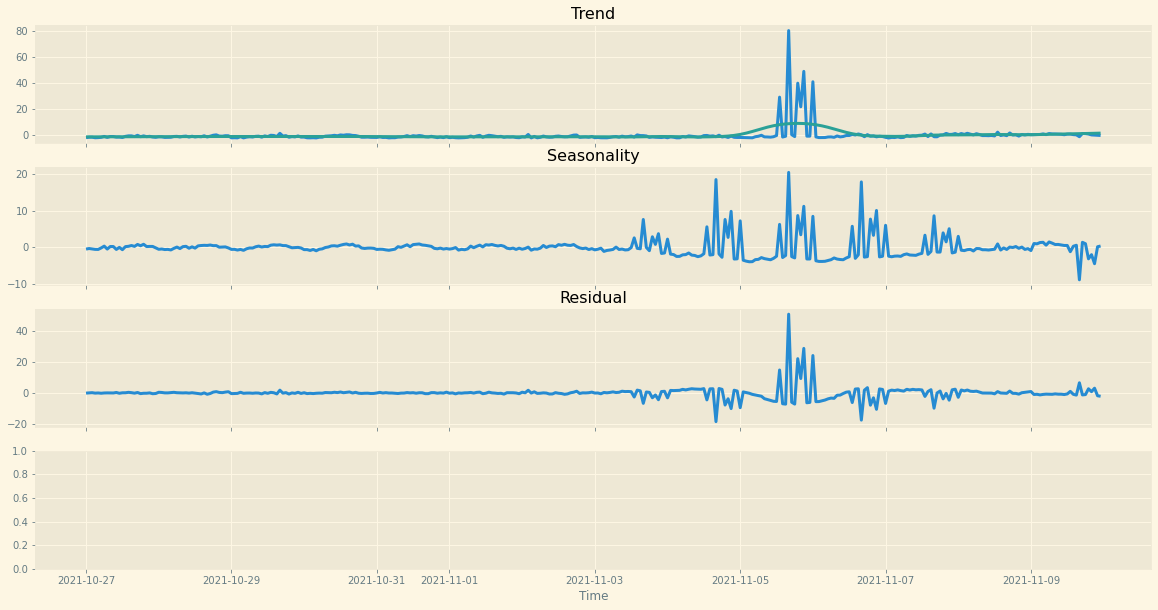

In [16]:
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.consts import TimeSeriesData

df_pca1 = df_pca.copy()
df_pca1['value'] = df_pca1['comp1']
columns_to_drop = componentList
df_pca1 = df_pca1.drop(columns_to_drop, axis=1)

timeseries = TimeSeriesData(df_pca1)

decomposer = TimeSeriesDecomposition(timeseries, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()
plt.savefig("./images/timeSeriesDecomposition_"+data+".png")

### Using OutlierDetection for finding anomaly

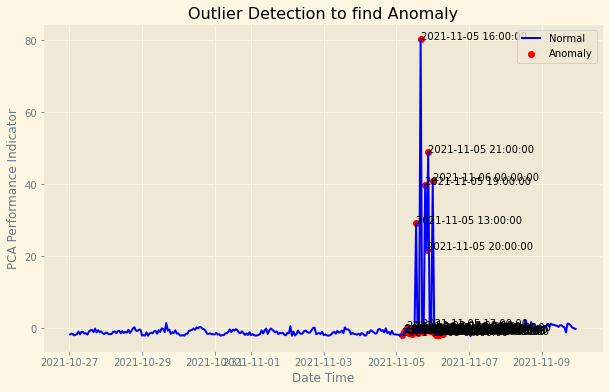

In [17]:
from kats.detectors.outlier import OutlierDetector
tsd = TimeSeriesData(df_pca1)
ts_outlierDetection = OutlierDetector(tsd)
ts_outlierDetection.detector()

df_plot['anomaly5'] = np.where(df_plot['day'].isin(ts_outlierDetection.outliers[0]), 0, 1)

fig, ax = plt.subplots(figsize=(10,6))
#df['hasimage'] = np.where(df['photos']!= '[]', True, False)
# a = df_plot.loc[(df_plot['anomaly4'] > 0) |  (df_plot['anomaly4'] > 1), ['day', 'comp1']] #anomaly
a = df_plot[df_plot['day'].isin(ts_outlierDetection.outliers[0])]
ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
plt.legend()
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('Outlier Detection to find Anomaly')
plt.savefig("./images/outlierDetection_"+data+".png")
plt.show();

### Using IsolationForest for finding anomaly

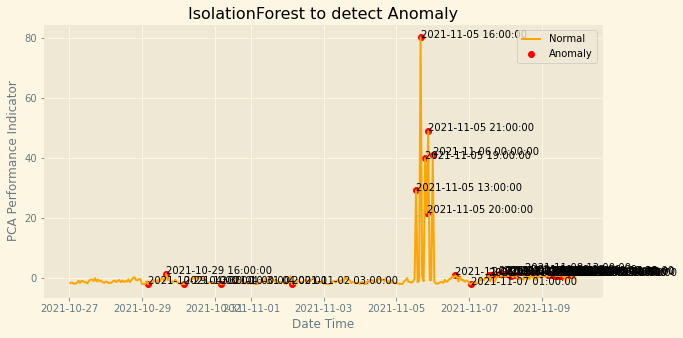

In [18]:
from sklearn.ensemble import IsolationForest
def doIsolationForest(dataset):
    # Isolation forest 
    outliers_fraction = 0.1
    ifo = IsolationForest(contamination = outliers_fraction)
    ifo.fit(reduced_data_set)
    df_plot['anomaly_if'] = pd.Series(ifo.predict(dataset))
    fig, ax = plt.subplots(figsize = (10, 5))
    a = df_plot.loc[df_plot['anomaly_if'] == -1, ['day', 'comp1']]
    ax.plot(df_plot['day'], df_plot['comp1'], 
            color = 'orange', label = 'Normal')
    ax.scatter(a['day'], a['comp1'], 
               color = 'red', label = 'Anomaly')
    plt.legend()
    for index, row in a.iterrows():
        day = row['day']
        comp1 = row['comp1']
        plt.text(day, comp1 , day)
    plt.xlabel('Date Time')
    plt.ylabel('PCA Performance Indicator')
    plt.title('IsolationForest to detect Anomaly')
    plt.savefig("./images/IsolationForest_"+data+".png")
    plt.show();
    
doIsolationForest(reduced_data_set)

### Using DBSCAN for anomaly detection

(array([-1,  0]), array([  6, 330]))


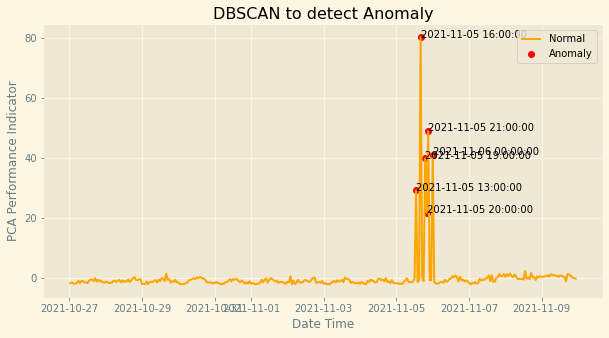

In [19]:
from sklearn.cluster import DBSCAN
def doDBSCAN(dataset):
    dbscan = DBSCAN(eps=0.6, min_samples=2)
    dbscan_result = dbscan.fit_predict(dataset)
    return dbscan_result

dbscan_result = doDBSCAN(reduced_data_set);
df_plot['anomaly_dbscan'] = pd.Series(dbscan_result)
print ( np.unique(dbscan_result, return_counts=True))
fig, ax = plt.subplots(figsize = (10, 5))
a = df_plot.loc[df_plot['anomaly_dbscan'] == -1, ['day', 'comp1']]
ax.plot(df_plot['day'], df_plot['comp1'], 
        color = 'orange', label = 'Normal')
ax.scatter(a['day'], a['comp1'], 
           color = 'red', label = 'Anomaly')

plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('DBSCAN to detect Anomaly')
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.savefig("./images/dbscan_"+data+".png")
plt.legend()
plt.show();

In [20]:
df_plot['anomaly_all'] = 0
df_plot['anomaly_all'] = np.where(df_plot['anomaly3'] == -1, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly4'] > 0, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly5'] == 0, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly_if'] == -1, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly_dbscan'] == -1, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot.head()

,day,BTS_ID,RRC_Conn_Release_due_to_S1_Link_Fail,Max_Num_RRC_Conn_User,Mean_RRC_Conn_Setup_Time_ms,Avg_PRACH_Usage_per_Second,FDD_Cell_DL_Avg_Agg_Thruput_Mbps,FDD_Cell_UL_Avg_Agg_Thruput_Mbps,FDD_Cell_DL_MAC_Data_Volume_MB,FDD_Cell_UL_MAC_Data_Volume_MB,...,RSSI_Avg_dBm,PRACH_Avg_NI_dBm,Power_DL_Avg_mw,anomaly3,comp1,anomaly4,anomaly5,anomaly_if,anomaly_dbscan,anomaly_all
0,2021-10-27 00:00:00,10-1,0.0,11.0,13355.0,0.163611,4.56,0.79,47.054162,20.450675,...,-98.957260,-120.0,7834.25,-1,-1.845746,0,1,1,0,1
1,2021-10-27 01:00:00,10-1,0.0,11.0,13909.0,0.220555,7.18,0.78,130.268487,23.455875,...,-98.656559,-120.0,8427.25,1,-1.517364,0,1,1,0,0
2,2021-10-27 02:00:00,10-1,0.0,12.0,12593.0,0.248611,2.52,0.41,144.003062,30.749775,...,-96.948088,-120.0,10168.50,1,-1.503065,0,1,1,0,0
3,2021-10-27 03:00:00,10-1,0.0,12.0,14232.0,0.166388,4.16,0.66,103.742800,25.223375,...,-98.226317,-120.0,8544.00,-1,-1.912222,0,1,1,0,1
4,2021-10-27 04:00:00,10-1,0.0,14.0,13922.0,0.165277,3.58,0.73,35.081687,17.426725,...,-99.252381,-120.0,7749.50,1,-1.808782,0,1,1,0,0


In [21]:
df_plot['anomaly_all'].unique()

array([1, 0, 2, 5])

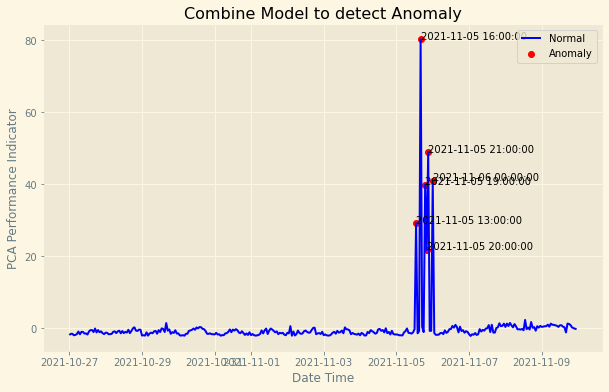

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
a = df_plot.loc[df_plot['anomaly_all'] > 2, ['day', 'comp1']] #anomaly
ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('Combine Model to detect Anomaly')
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)


plt.savefig("./images/MaxAnomalyInAllModel_"+data+".png")
plt.show();